# Extraction of landscape geometry features

In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from scipy import spatial
from scipy import stats
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
sns.set()

## Load the original data

Obtained from F. Poux's [video tutorial](https://www.youtube.com/watch?v=WKSJcG97gE4) on 3D point cloud feature extraction, available on [Google Drive](https://drive.google.com/drive/folders/1fwhE5OphpeW4RR0RY8W2jbqmlf5LH6dX).

In [4]:
fname = os.path.join('data', 'MLS_UTWENTE_super_sample.ply')
pcd = o3d.io.read_point_cloud(fname)

In [5]:
o3d.visualization.draw_geometries([pcd])

## Preprocessing

In [6]:
# translation
zmin = pcd.get_min_bound()[2]
trans = np.array([0, 0, -zmin])
pcd = pcd.translate(trans)

In [7]:
# colorization with regards to elevation
points = np.asarray(pcd.points)
elev = points[:, 2]
cmap = sns.color_palette(palette='viridis', as_cmap=True)
norm = plt.Normalize()
color = cmap(norm(elev))[:, :-1]
pcd.colors = o3d.utility.Vector3dVector(color)

In [8]:
o3d.visualization.draw_geometries([pcd])

## Exploring the unstructured data with an octree

In [9]:
octree = o3d.geometry.Octree(max_depth=7)
octree.convert_from_point_cloud(pcd, size_expand=0.01)

In [10]:
o3d.visualization.draw_geometries([octree])

## Downsampling the point cloud using a voxel grid

In [11]:
pcd_ds = pcd.voxel_down_sample(voxel_size=0.8)  # cca. 10x downsample

In [12]:
o3d.visualization.draw_geometries([pcd_ds])

## Removing outliers

In [13]:
def display_inlier_outlier(cloud, ind):
    if not isinstance(cloud, o3d.geometry.PointCloud):
        points = cloud
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(np.asarray(points))
    inlier = cloud.select_by_index(ind)
    outlier = cloud.select_by_index(ind, invert=True)
    outlier.paint_uniform_color([1, 0, 0])
    inlier.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier, outlier])

In [14]:
pcd_stat, ind = pcd_ds.remove_statistical_outlier(nb_neighbors=30,
                                                  std_ratio=3)

In [15]:
display_inlier_outlier(pcd_ds, ind)

In [16]:
pcd_rad, ind = pcd_ds.remove_radius_outlier(nb_points=25, radius=5)

In [17]:
display_inlier_outlier(pcd_ds, ind)

In [18]:
o3d.visualization.draw_geometries([pcd_rad])

## Final cleaning touches on the point cloud

In [19]:
# https://www.open3d.org/html/tutorial/Advanced/interactive_visualization.html
# o3d.visualization.draw_geometries_with_editing([pcd_rad])

In [20]:
fname = os.path.join('data', 'MLS_UTWENTE_super_sample_crop.ply')
pcd_crop = o3d.io.read_point_cloud(fname)

In [21]:
o3d.visualization.draw_geometries([pcd_crop])

## Extracting geometric features

In [25]:
X = np.asarray(pcd_crop.points)

### In 3D

In [26]:
def pca(X):
    X_norm = X - np.mean(X, axis=0)
    cov = np.cov(X_norm, rowvar=False)
    eval, evec = np.linalg.eig(cov)
    mask = np.argsort(eval)[::-1]
    return eval[mask], evec[mask]

In [27]:
def extract_features(eval, evec):
    # https://doi.org/10.5194/isprsannals-II-5-W2-313-2013
    planarity = (eval[1] - eval[2]) / eval[0]
    linearity = (eval[0] - eval[1]) / eval[0]
    omnivariance = (eval[0] * eval[1] * eval[2]) ** (1 / 3)
    _, _, normal = evec
    verticality = 1 - normal[2]
    return (planarity, linearity, omnivariance, verticality,
            normal[0], normal[1], normal[2])

In [28]:
tree = spatial.KDTree(X)
dist, ind = tree.query(X, k=25)
nbhd = X[ind]

In [29]:
# example for a single point
sel = 0
eval, evec = pca(nbhd[sel])
p, l, o, v, nx, ny, nz = extract_features(eval, evec)

In [30]:
p, l, o, v, nx, ny, nz

(0.28356258122852246,
 0.3883945586882647,
 1.0803330542707343,
 0.9764970164231218,
 0.6649420291561052,
 0.7465250884094561,
 0.02350298357687823)

In [31]:
# surface normals
n = np.empty_like(X)
for i in range(X.shape[0]):
    eval, evec = pca(nbhd[i, ...])
    _, _, _, _, nx, ny, nz = extract_features(eval, evec)
    n[i, :] = [nx, ny, nz]
pcd_crop.normals = o3d.utility.Vector3dVector(n)
pcd_crop.orient_normals_consistent_tangent_plane(20)

In [32]:
o3d.visualization.draw_geometries([pcd_crop], point_show_normal=True)

### 2D

In [33]:
def display_selection(cloud, ind):
    if not isinstance(cloud, o3d.geometry.PointCloud):
        points = cloud
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(np.asarray(points))
    selected = cloud.select_by_index(ind)
    unselected = cloud.select_by_index(ind, invert=True)
    selected.paint_uniform_color([1, 0, 0])
    unselected.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([selected, unselected])

In [34]:
tree_2d = spatial.KDTree(X[:, :2])
ind_2d = tree_2d.query_ball_point(X[:, :2], 4)

In [35]:
# example for a single selection
sel = 0
X_sel = X[ind_2d[sel]]

In [36]:
display_selection(X, ind_2d[sel])

In [37]:
# create a distribution of elevations of the scenary
elevs = []
for i in range(X.shape[0]):
    X_sel = X[ind_2d[i]]
    elevs.append(X_sel[:, 2].ptp())

In [38]:
kernel = stats.gaussian_kde(elevs)

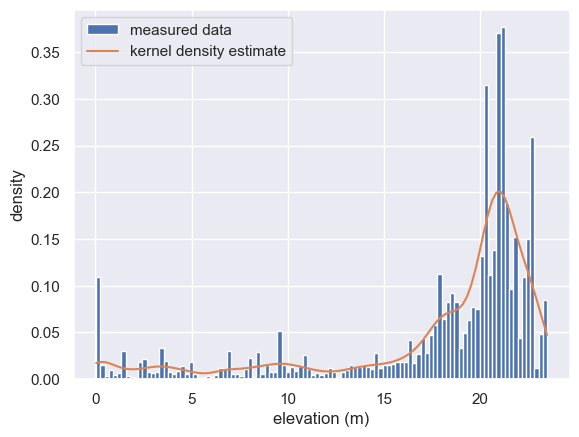

In [39]:
fig, ax = plt.subplots()
y, bins, patches = ax.hist(elevs,
                           bins='fd',
                           density=True,
                           cumulative=False,
                           histtype='bar',
                           align='mid',
                           orientation='vertical',
                           label='measured data')
ax.plot(bins, kernel(bins), label='kernel density estimate')
ax.set(xlabel='elevation (m)', ylabel='density')
ax.legend();

In [40]:
kernel.integrate_box_1d(min(elevs), max(elevs))

0.9635174714039083

In [41]:
kernel.integrate_box_1d(10, 15)

0.060001396507266824

In [42]:
kernel.covariance

array([[0.48386452]])

In [43]:
kernel.covariance_factor()

0.11727856248680578

## Extracting the flat terrain

In [44]:
def display_plane(cloud, ind):
    if not isinstance(cloud, o3d.geometry.PointCloud):
        points = cloud
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(np.asarray(points))
    planar = cloud.select_by_index(ind)
    nonplanar = cloud.select_by_index(ind, invert=True)
    planar.paint_uniform_color([1, 0, 0])
    nonplanar.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([planar, nonplanar])

In [52]:
o3d.utility.random.seed(42)

In [53]:
plane_model, ind = pcd_crop.segment_plane(distance_threshold=0.5,
                                          ransac_n=3,
                                          num_iterations=1000)

In [56]:
a, b, c, d = plane_model
print(f'implicit eqn. ({a:.2e}) x + ({b:.2e}) y + ({c:.2e}) z + ({d:.2e}) = 0')

implicit eqn. (-3.80e-03) x + (-3.63e-04) y + (1.00e+00) z + (-6.84e-03) = 0


In [57]:
display_plane(pcd_crop, ind)

## Estimating the surface area of the flat terrain

In [58]:
pcd_flat = pcd_crop.select_by_index(ind)
pcd_flat.paint_uniform_color(sns.color_palette()[0])
obb = pcd_flat.get_oriented_bounding_box()
obb.color = sns.color_palette()[1]

In [59]:
o3d.visualization.draw_geometries([pcd_flat, obb])

In [60]:
# the surface area is approximated without taking accounting for the elevation
# of the flat terrain
surface_area = obb.extent[0] * obb.extent[1]
surface_area

8115.831840955457